In [74]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
import pandas as pd
sys.path.append(os.path.dirname(os.getcwd()))
from functions_roman_rubin import sim_fit,sim_event
from functions_roman_rubin import model_rubin_roman, fit_rubin_roman
from functions_roman_rubin import read_data, save
from tqdm.auto import tqdm

/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The aim of this notebook is to evaluate the impact of the width of the interval within which the variable can move during the fit.

In [75]:

current_path = os.path.dirname(os.getcwd())
# print(current_path)
i=18 #select one event by its index in the TRILEGAL set
model='USBL'

path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

### The event that we want to simulate have the following parameters

In [76]:
pd_planets = pd.read_csv(path_TRILEGAL_set)
event_params = pd_planets.iloc[int(i)]
print(event_params)

u                                  24.853
g                                   22.55
r                                  21.529
i                                  21.133
z                                  20.945
Y                                  20.828
W149                              20.8178
radius                           0.513042
D_S                                  5156
D_L                                  2817
mu_rel                           5.147491
m_planet    9.462530108421484 jupiterMass
m_star          18.65259824621826 solMass
t0                         2462592.427461
te                             351.034363
u0                               0.147437
rho                              0.000094
piEE                            -0.032015
piEN                             0.005886
s                                 1.14786
q                                0.000484
alpha                            2.170221
Name: 18, dtype: object


## First we simulate the event 
The relevant code for this is the function sim_event(i, event_params, path_ephemerides, path_dataslice, model).

The output:

model(eg: pyLIMA.models.USBL_model.USBLmodel): the light curves, telescope name, etc.  
pyLIMA_parameters (dictionary): PyLIMA parameters.
decision (boolean): is made based on the detection criteria. This boolean is True if the event is a suitable candidate for fitting.

In [77]:

my_own_model, pyLIMA_parameters, decision = sim_event(i, event_params, path_ephemerides, path_dataslice,model)

/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: 

Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['third_caustic', [0, 0]]
A good event to fit


In [78]:
print('if the criterias are satisfied by this event we obtain "True":', decision)

if the criterias are satisfied by this event we obtain "True": True


In [79]:
if decision:
    print("Save the simulated event")
    save(i, path_TRILEGAL_set, path_to_save_model, my_own_model, pyLIMA_parameters)



Save the simulated event
Saving...
File saved: /home/anibal-pc/roman_rubin/test_sim_fit/Event_18.h5


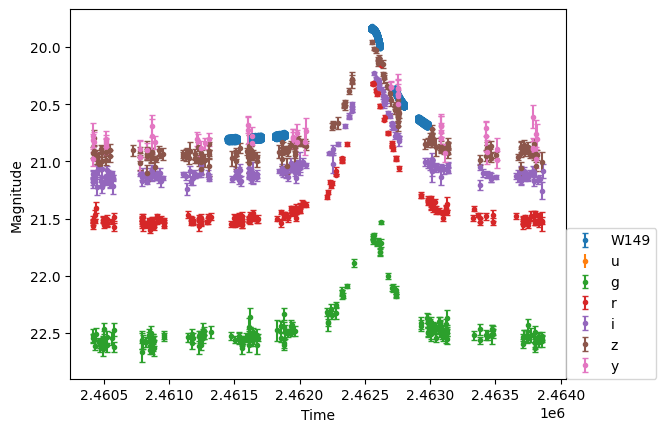

In [80]:
#plot without alignment

telescopes = my_own_model.event.telescopes

for telo in telescopes:
    plt.errorbar(telo.lightcurve_magnitude['time'],telo.lightcurve_magnitude['mag'],telo.lightcurve_magnitude['err_mag'],ls='',marker='.',capsize=2,label=telo.name)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc=(1,0))
plt.gca().invert_yaxis()
plt.show()

## Plot this event with pyLIMA

We can use the functionality of pyLIMA to make plot with aligned data in order to see the peak asociated to a planet of this particular event

Comment on pyLIMA:

To plot these events, since in our model we use the positions of Gaia with a shift in time,
it is necessary to modify the pyLIMA code as follows:

 In /pyLIMA/toolbox/fake_telescopes.py, we must add 'spacecraft_positions' to the list
 in the function:

 replicate_a_telescope(microlensing_model, telescope_index, light_curve_time=None,
                        astrometry_curve_time=None):

 attributes_to_copy = ['name', 'filter', 'location', 'ld_gamma', 'ld_sigma', 'ld_a1',
                       'ld_a2', 'ld_gamma1', 'ld_gamma2', 'location', 'spacecraft_name',
                       'spacecraft_positions', 'pixel_scale']



In [81]:
info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
ulens_params = []
PAR = ['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE']

for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []

# Here we change the zero point to the pyLIMA convention in order to make the alignment
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params


In [82]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)


check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g (Rubin): SUCCESS
Parallax(Full) estimated for the telescope r (Rubin): SUCCESS
Parallax(Full) estimated for the telescope i (Rubin): SUCCESS
Parallax(Full) estimated for the telescope z (Rubin): SUCCESS
Parallax(Full) estimated for the telescope y (Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA 

In [83]:

if len(true_params) != len(model_true.model_dictionnary):
    telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
    telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
                         telescopes_fluxes]#._fields]
    model_parameters3 = np.r_[true_params, telescopes_fluxes]
else:
    model_parameters3 = true_params


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 92359 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 92359 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 72585 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g (Rubin): SUCCESS


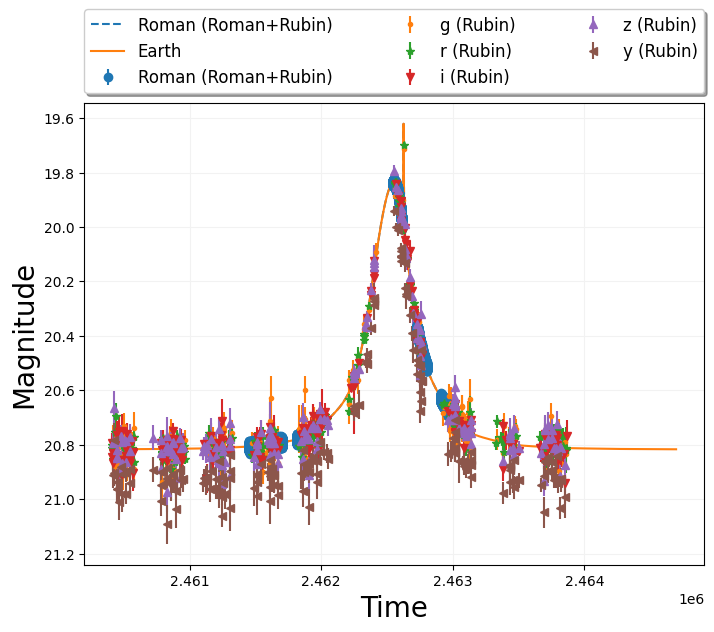

In [84]:
fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()

pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()


# Fits

Relevant Function: 

fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,
                               band_roman, band_rubin_u, band_rubin_g, band_rubin_r,
                                           band_rubin_i, band_rubin_z, band_rubin_y)

This function performs the fitting of microlensing events using data from both the Rubin Observatory (LSST) and the Roman Space Telescope (WFIRST). It supports various microlensing models, including Finite-Source Point Lens (FSPL), Uniform Source Binary Lens (USBL), and Point Source Point Lens (PSPL). Additionally, the function accommodates multiple fitting algorithms, such as Trust Region Reflective (TRF), Markov Chain Monte Carlo (MCMC), and Differential Evolution (DE).

The boundaries used for the fitting process can be modified within the function's script.



In [85]:
algo = 'TRF'

gamma_rr = []
gamma_roman = []
alpha_rr = []
alpha_roman = []
beta_rr = []
beta_roman = []

for rango in tqdm([0.01, 0.1 ,0.2,0.5,1,2,3,4,5]):
    
    Source = i
    if decision:
        lc_to_fit = {}
        for telo in my_own_model.event.telescopes:
            if not len(telo.lightcurve_magnitude['mag'])==0:
                df = telo.lightcurve_magnitude.to_pandas()
                lc_to_fit[telo.name] = df.values
            else:
                lc_to_fit[telo.name] = []
        origin = my_own_model.origin
        fit_rr, event_fit_rr, pyLIMAmodel_rr = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,rango,
                                   lc_to_fit["W149"], lc_to_fit["u"], lc_to_fit["g"], lc_to_fit["r"],
                                               lc_to_fit["i"], lc_to_fit["z"],lc_to_fit["y"])
        fit_roman, event_fit_roman, pyLIMAmodel_roman = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,rango,
                                   lc_to_fit["W149"], [], [], [], [], [],[])
        
        gamma_roman.append(np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_roman.fit_results['best_model'])]))
        gamma_rr.append((np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])])
        alpha_roman.append(abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/np.array(true_params[0:len(fit_roman.fit_results['best_model'])]))
        alpha_rr.append((abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])])
        #metric beta
        beta_roman.append(abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/abs(np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix']))))
        beta_rr.append((abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix'])))[0:len(fit_roman.fit_results['best_model'])])



  0%|                                                     | 0/9 [00:00<?, ?it/s]

check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA 

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438, 198.17008039184716, 115.85956729838873, 182.22793064946242, 166.46665663900635, 228.6265740239188, 198.9413151678031, 276.50461678243636, 218.25714149463693]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2462560.608463868, 0.3056297481188683, 354.54470696864246, 9.447202261785927e-05, 1.1513369708343415, 0.0004891117755591963, 2.1485189120117947, 0.005944680906306472, -0.031695140127418774, 260.9857964520662, 435.40541909880204, 47.594020614217804, 87.86731841710908, 197.2834687495488, 225.79063124409075, 178.2954472959626, 324.57645208668924, 224.70645059273983, 385.59267504925003, 264.27942855317093, 418.8221920354865] chi2 174647.154449987
check_event  

 11%|████▉                                       | 1/9 [02:30<20:05, 150.63s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462560.651689801, 0.3056297481185767, 354.54470696860267, 9.44720224749284e-05, 1.1520884269960476, 0.0004891117751291877, 2.148518912025502, 0.0059446809061403875, -0.031695140127793994, 260.9610020652114, 435.40185898445] chi2 172127.9847573571
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438, 19

 22%|█████████▊                                  | 2/9 [05:24<19:10, 164.37s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462545.209255268, 0.33286408210965684, 369.76128862274356, 8.418300307825403e-05, 1.0330739361849475, 0.00043584217624386003, 1.953199010927508, 0.005297240411562061, -0.028813763752198025, 293.85426985021337, 430.67204964956096] chi2 97666.53746024617
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.953774912904

 33%|██████████████▋                             | 3/9 [08:59<18:43, 187.24s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462549.278706109, 0.30863880475417227, 395.03884018905393, 0.00010808584755540914, 1.2401183839473344, 0.00045736903751639446, 2.1728928234611486, 0.006702882758518459, -0.032848429545093906, 268.8140590024295, 429.48124570006013] chi2 41909.3400230788
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.953774912904

 44%|███████████████████▌                        | 4/9 [12:43<16:48, 201.73s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462549.3386994926, 0.30674443652360467, 396.1234263100712, 0.00012992859597455643, 1.1488100909974663, 0.0005605087032020463, 2.1965176008088454, 0.0068139067209566145, -0.03262608866567226, 266.787253440941, 429.46842621419177] chi2 41904.669549771075
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.953774912904

 56%|████████████████████████▍                   | 5/9 [18:56<17:34, 263.71s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462549.338245504, 0.3067909963173124, 396.08881769051607, 0.0001870733083697855, 1.1488460480851552, 0.0005603657814879297, 2.1964721495812176, 0.006803298298724395, -0.03262795444873607, 266.84061656697236, 429.46871923121194] chi2 41904.67603985591
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438

 67%|█████████████████████████████▎              | 6/9 [24:50<14:42, 294.31s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462549.298170593, 0.30749930232647305, 395.828554291587, 8.103195664572984e-05, 1.2394566092511954, 0.00045880053279637726, 2.173831706050384, 0.00689098181747531, -0.03276273427252898, 267.5022869754472, 429.4734136657337] chi2 41909.357058585345
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438, 1

 78%|██████████████████████████████████▏         | 7/9 [32:10<11:23, 341.85s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462545.209255268, 0.3165488575432009, 393.6474409410041, -0.00014472601829702977, 0.9969994362085787, -0.0009685381694308, 2.1813762805028962, 0.006197887242522083, -0.03145567880174381, 274.8694935677653, 429.1291615096829] chi2 42180.50703251832
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608134, 227.1020197745454, 49.16169266311294, 44.95377491290438, 1

 89%|███████████████████████████████████████     | 8/9 [40:05<06:24, 384.42s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462545.209255268, 0.31415694782374604, 396.36464329733025, -3.7038263629943024e-05, 0.9711705500477558, -0.001452807254108505, 2.20824181548387, 0.00765082789408923, -0.031795918949218786, 271.2036813068471, 429.13382182475993] chi2 42136.23900742795
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438

100%|████████████████████████████████████████████| 9/9 [45:02<00:00, 300.27s/it]

fit  : Trust Region Reflective fit SUCCESS
best_model: [2462565.209255267, 0.1682400900268933, 515.4664854574664, 0.0005612199363440377, 0.9762110291040289, -0.0017957678633685782, 1.0835212544319661, -0.010153862996912465, -0.0013637805327768066, 120.44607350510279, 427.509535348703] chi2 48195.04171165595


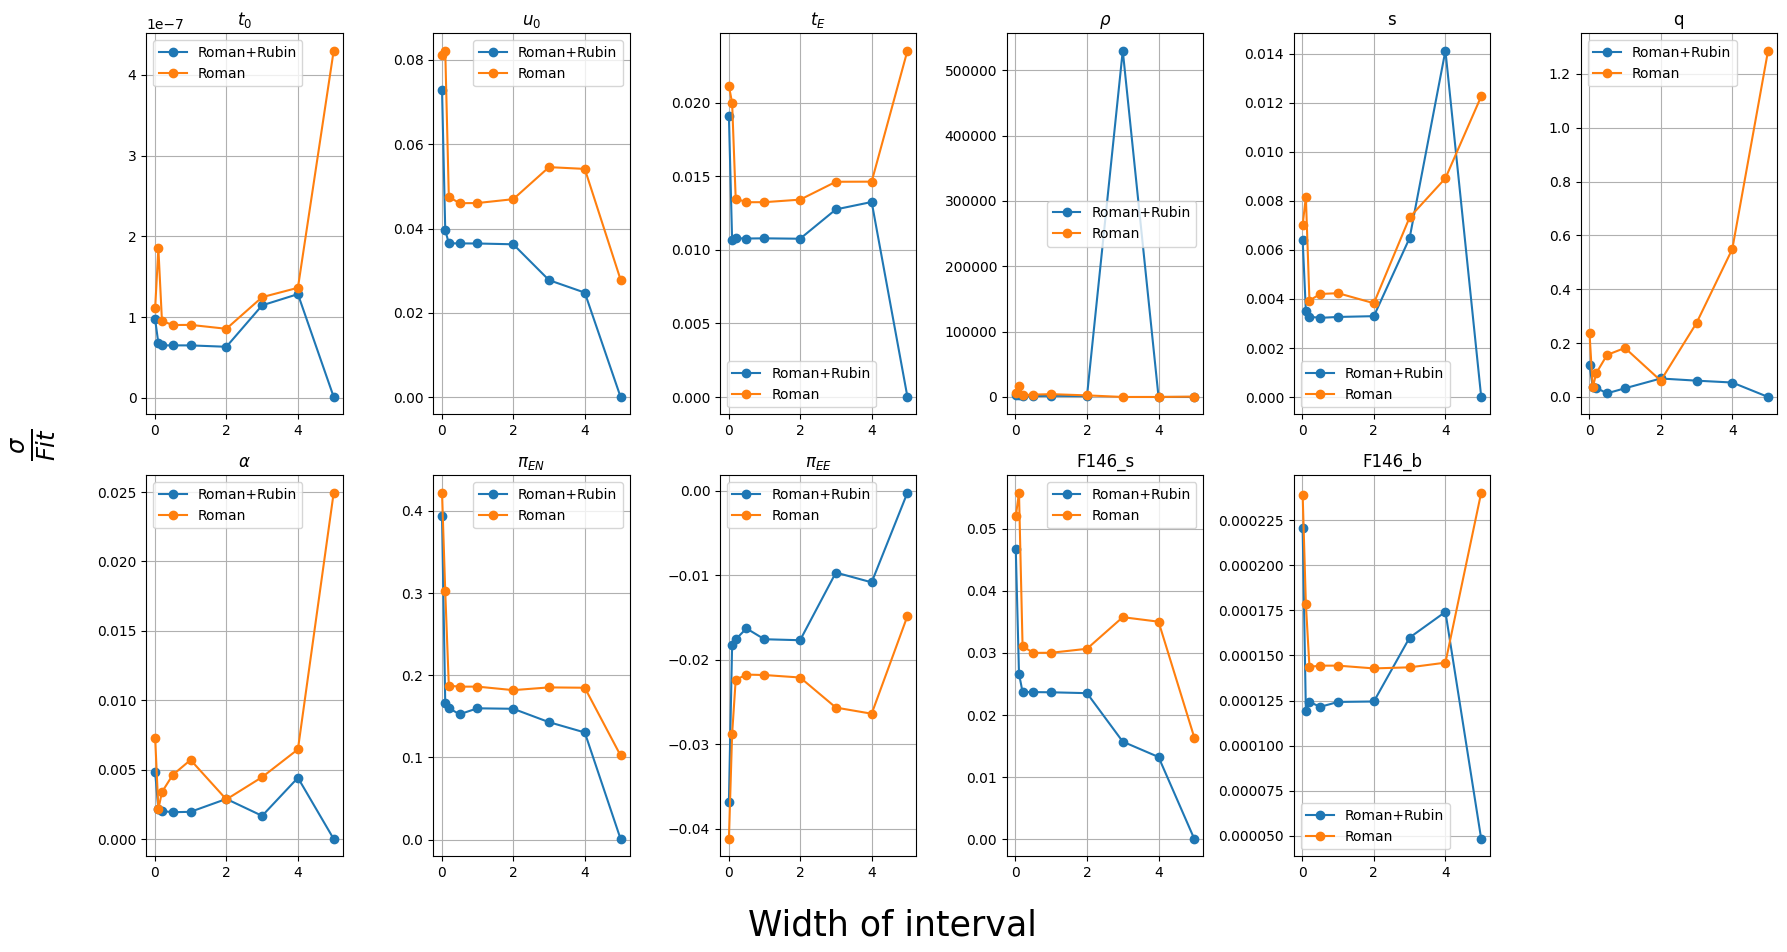

In [118]:
xticks = [
    r'$t_0$', r'$u_0$', r'$t_E$', r'$\rho$', 's', 'q',
    r'$\alpha$', r'$\pi_{EN}$', r'$\pi_{EE}$', 'F146_s', 'F146_b'
]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 10))
fig.delaxes(axes[1, 5])  # Remove extra plot

for j, ax in enumerate(axes.flatten()):
    if j >= len(xticks):
        break

    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [gamma_rr[i][j] for i in range(9)], marker='o', label="Roman+Rubin")
    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [gamma_roman[i][j] for i in range(9)], marker='o', label="Roman")

    ax.set_title(xticks[j], fontsize=12)
    ax.grid(True)
    ax.legend(loc='best')

# Adding a single x-label at the bottom and y-label on the left
fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
fig.text(0.01, 0.5, r"$\frac{\sigma}{Fit}$", va='center', rotation='vertical', fontsize=25)
# plt.
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to fit axis labels
plt.show()


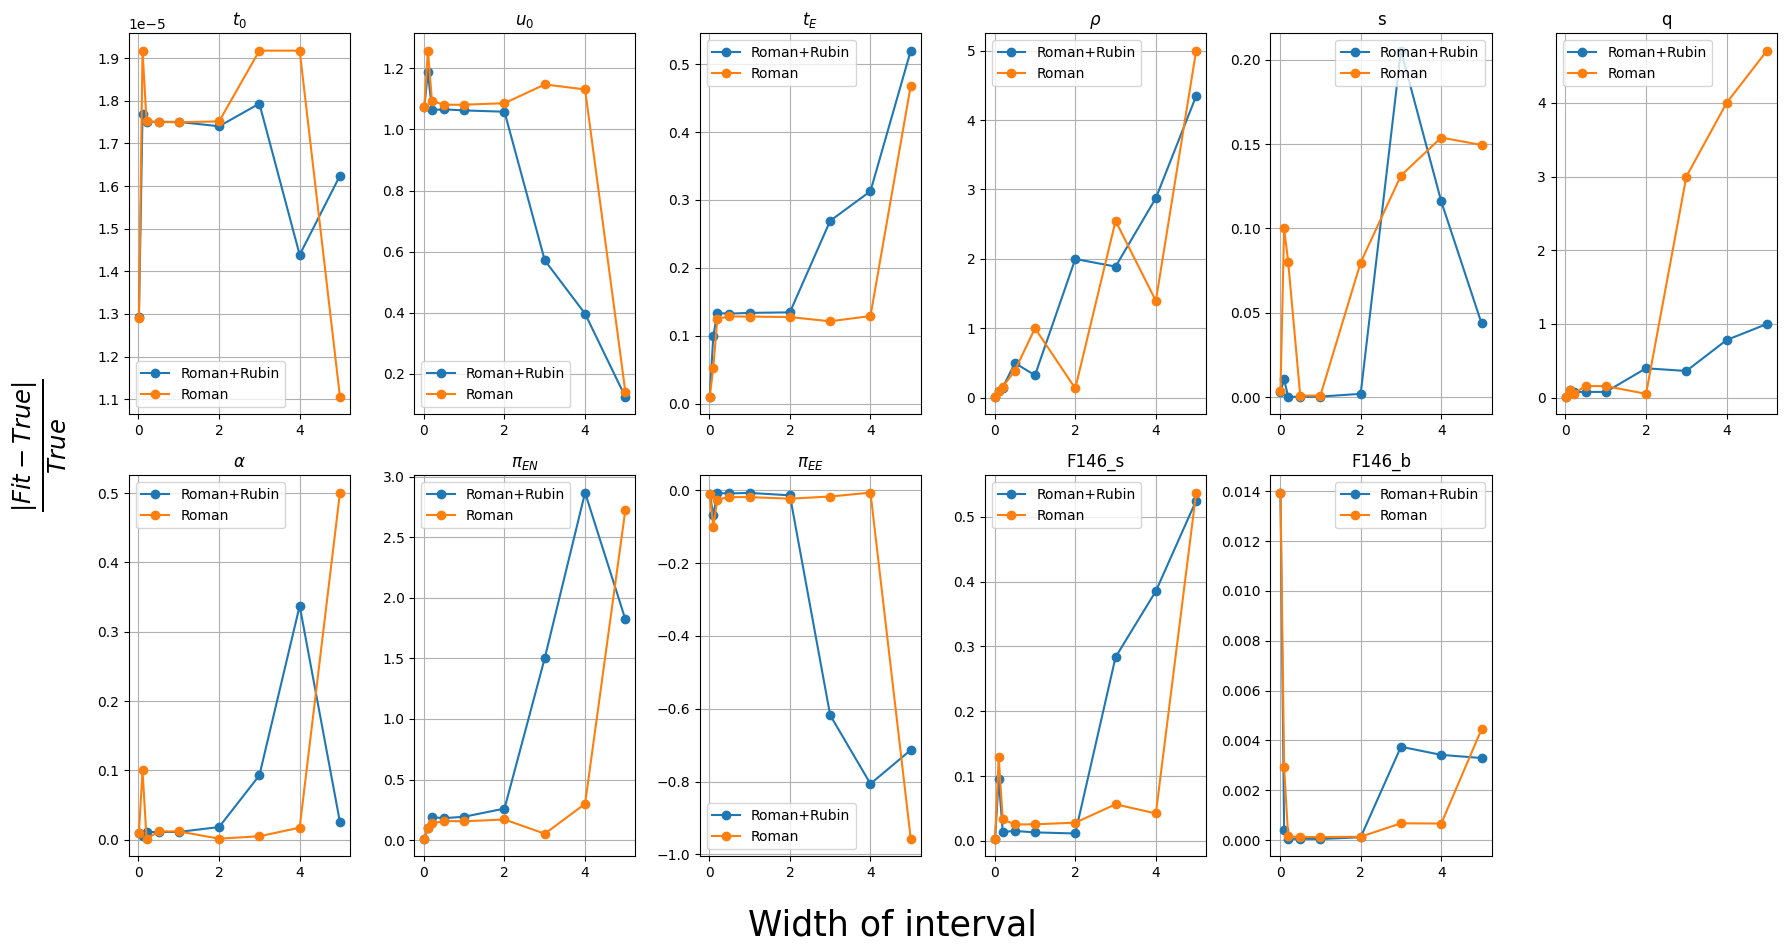

In [119]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 10))
fig.delaxes(axes[1, 5])  # Remove extra plot

for j, ax in enumerate(axes.flatten()):
    if j >= len(xticks):
        break

    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [alpha_rr[i][j] for i in range(9)], marker='o', label="Roman+Rubin")
    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [alpha_roman[i][j] for i in range(9)], marker='o', label="Roman")

    ax.set_title(xticks[j], fontsize=12)
    ax.grid(True)
    ax.legend(loc='best')

# Adding a single x-label at the bottom and y-label on the left
fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
fig.text(0.01, 0.5, r"$\frac{|Fit-True|}{True}$", va='center', rotation='vertical', fontsize=25)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to fit axis labels
plt.show()


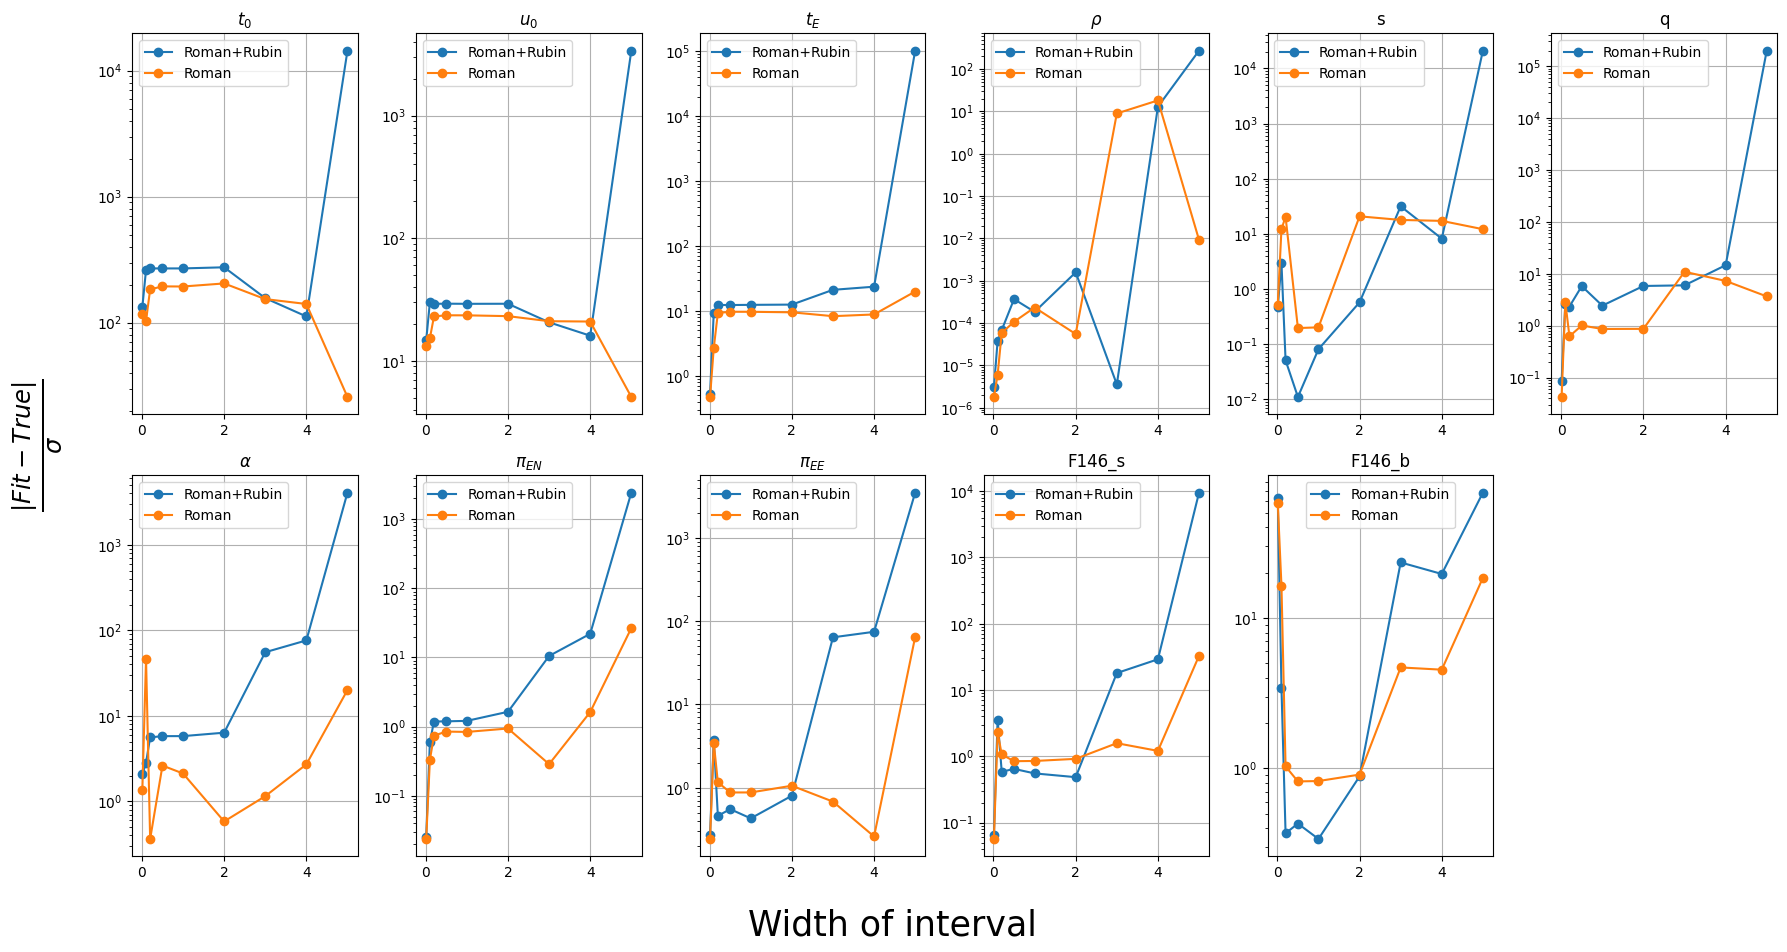

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 10))
fig.delaxes(axes[1, 5])  # Remove extra plot

for j, ax in enumerate(axes.flatten()):
    if j >= len(xticks):
        break

    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [beta_rr[i][j] for i in range(9)], marker='o', label="Roman+Rubin")
    ax.plot([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5],
            [beta_roman[i][j] for i in range(9)], marker='o', label="Roman")

    ax.set_title(xticks[j], fontsize=12)
    ax.grid(True)
    ax.set_yscale("log")
    ax.legend(loc='best')
    
# Adding a single x-label at the bottom and y-label on the left
fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
fig.text(0.01, 0.5, r"$\frac{|Fit-True|}{\sigma}$", va='center', rotation='vertical', fontsize=25)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to fit axis labels
plt.show()
